<a href="https://colab.research.google.com/github/i-bthn/DeepLearning/blob/main/pneumonia_detection_using_chest_x_rays_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.7

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Activation,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping ###
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import precision_recall_curve,roc_curve,accuracy_score,confusion_matrix,precision_score,recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import seaborn as sns
plt.style.use('fivethirtyeight')

import pickle 
import cv2
import os
%matplotlib inline



In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
from google.colab import drive 
drive.mount('/content/drive' , force_remount=True )

Mounted at /content/drive


In [ ]:
import pandas as pd
import json

#url = ("/content/drive/MyDrive/chest_xray/")
#input_path = pd.read_json(url)

# url_train = ('/content/drive/MyDrive/DL_train')
# url_test = ('/content/drive/MyDrive/DL_test')
# url_val = ('/content/drive/MyDrive/DL_val')

# train = pd.DataFrame(url_train)
# test = pd.DataFrame(url_test)
# val = pd.DataFrame(url_val)

In [ ]:
# train = ('/content/drive/MyDrive/DL_train')
# test = ('/content/drive/MyDrive/DL_test')
# val = ('/content/drive/MyDrive/DL_val')

In [ ]:
train = get_training_data('/content/drive/MyDrive/DL_train')
test = get_training_data('/content/drive/MyDrive/DL_test')
val = get_training_data('/content/drive/MyDrive/DL_val')

<ipython-input-17-0c9285019f60>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


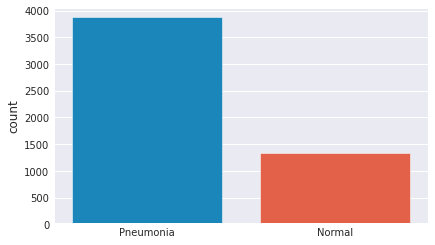

In [ ]:

l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l) 

In [ ]:
print("There is {} images in the training dataset".format(len(train)))
print("There is {} images in the test dataset".format(len(test)))
print("There is {} images in the validation dataset".format(len(val)))


There is 5216 images in the training dataset
There is 624 images in the test dataset
There is 16 images in the validation dataset


In [ ]:
########### maybe no need ##################
pnenumonia = 0
normal = 0
for i, j in train:
  if j == 0:
      pnenumonia+=1
  else:
      normal+=1

print ('Pneumonia:', pnenumonia)
print('Normal:', normal)
print( 'Pneumonia - Normal:', pnenumonia-normal )

Pneumonia: 3875
Normal: 1341
Pneumonia - Normal: 2534


#Visulalize training img

Text(0.5, 1.0, 'NORMAL')

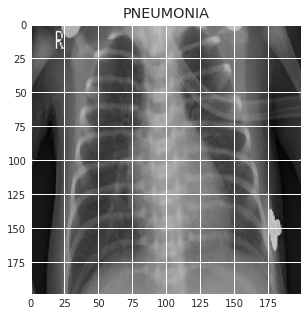

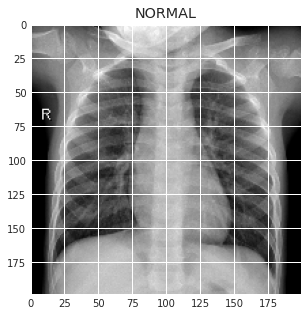

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
# Normalize the data
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255
x_val = np.array(x_val) / 255

In [ ]:
x_train.shape

(5216, 200, 200)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(x_train)
#datagen.fit(x_train.reshape(5216,28,28,1))
datagen.fit(x_train.reshape(5216,200, 200, 1))

# **CNN** - Building an model

In [ ]:
from tensorflow.keras.layers import MaxPool2D

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (200,200,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten(input_shape=(32,32,3)))  #this converts our 3D feature maps to 1D feature vectors

model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 200, 200, 32)      320       
                                                                 
 batch_normalization_5 (Batc  (None, 200, 200, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 dropout_4 (Dropout)         (None, 100, 100, 64)      0         
                                                                 
 batch_normalization_6 (Batc  (None, 100, 100, 64)    

In [ ]:
x_train.shape

(5216, 200, 200)

In [ ]:
x_val.shape

(16, 200, 200)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)


In [ ]:
#x = x_train.reshape(5216, 200,200,1)
history = model.fit(datagen.flow( x_train.reshape(5216, 200,200,1),y_train,batch_size=32),
                    epochs = 12 ,
                    validation_data = datagen.flow(x_val.reshape(16, 200, 200,1 ), y_val) ,
                    callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - ETA: 0s - loss: 0.6513 - accuracy: 0.8349

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
163/163 [==============================] - 79s 114ms/step - loss: 0.6513 - accuracy: 0.8349 - val_loss: 28.9615 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 18s 111ms/step - loss: 0.2931 - accuracy: 0.9020 - val_loss: 25.4061 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2323 - accuracy: 0.9155
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 23s 139ms/step - loss: 0.2323 - accuracy: 0.9155 - val_loss: 53.3975 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==========

In [ ]:
x = np.array(x_test.reshape(-1, 200,200,1)) #-1 make this array 1D
y = np.array(y_test)

print("Loss of the model is - " , model.evaluate(x,y)[0])
print("Accuracy of the model is - " , model.evaluate(x,y)[1]*100 , "%")

20/20 [==============================] - 0s 22ms/step - loss: 0.3628 - accuracy: 0.9087
Loss of the model is -  0.3627870976924896
20/20 [==============================] - 0s 21ms/step - loss: 0.3628 - accuracy: 0.9087
Accuracy of the model is -  90.86538553237915 %


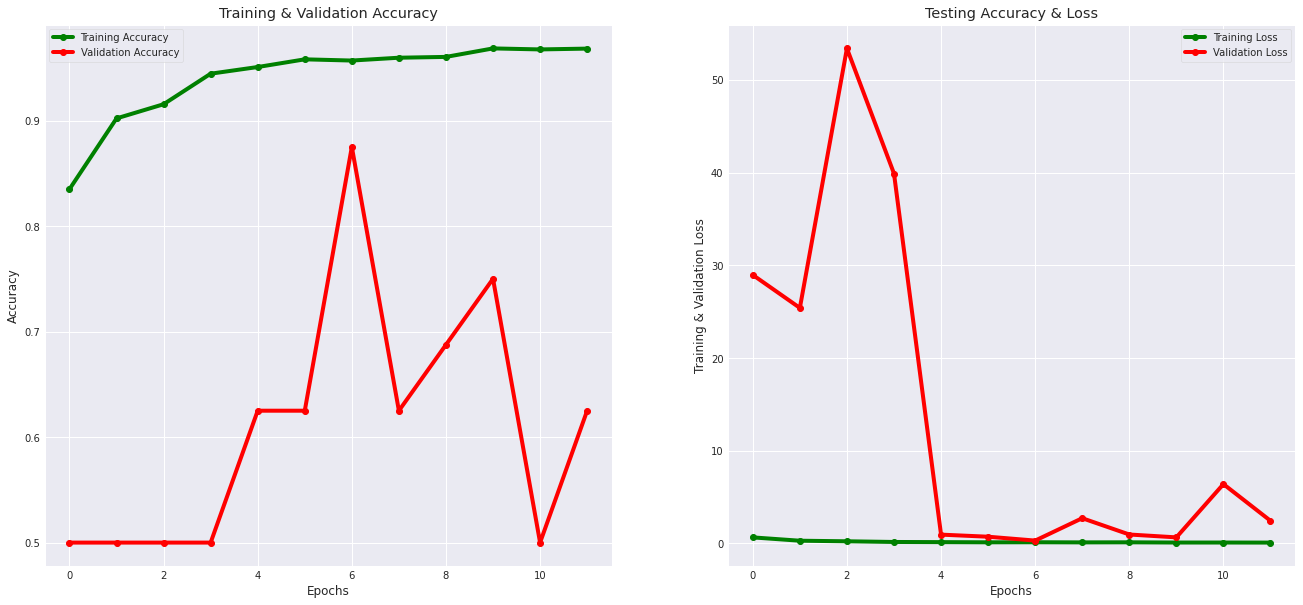

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = np.argmax(model.predict(x), axis=-1)


20/20 [==============================] - 0s 21ms/step


In [ ]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.62      1.00      0.77       390
   Normal (Class 1)       0.00      0.00      0.00       234

           accuracy                           0.62       624
          macro avg       0.31      0.50      0.38       624
       weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

array([[390,   0],
       [234,   0]])

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

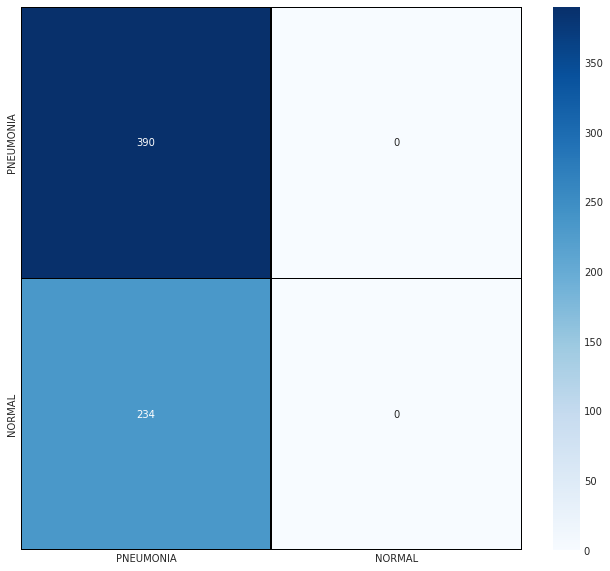

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

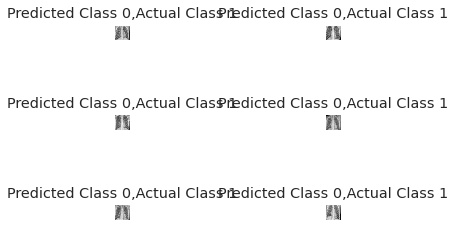

In [ ]:
#Some of the Incorrectly Predicted Classes

i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.imshow(x_test[c].reshape(200,200), cmap="gray", interpolation='none')

    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1